#### **T1**: Heat Transfer

This script calculates an equation for temperature $T$ from a set of voltage outputs from a thermocouple, $\Delta V$, based off the Seebeck voltage

\begin{equation}
    \Delta V = S \Delta T,
\end{equation}

where $S$ is the Seebeck coeffecient for the conductor being considered. This script is designed for Chromel and Alumel wires which behave approximately linearly in this setup, so it can be assumed that:

\begin{equation}
    \Delta V = \alpha(T_p - T_r).
\end{equation}

$\alpha$ is a combination of Seebeck coeffecients of the two conductors and $T_p$ is the temperature of the measuring point and $T_r$ is the temperature of the reference junction.

This script then uses the calibration data to calculate the thermal coeffecient $\beta$ from time-voltage data, testing Newton's Law of Cooling.

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sympy as sp
from error_propagation import propagate_error_pd

##### Thermocouple Calibration

Calibration data is processed and plotted to find a linear relationship between $V$ and $T$. Errors are also calculated for this fit.

In [40]:
# data variables
CALIBRATION_DATA_PATH = "thermocouple_calibration.csv"
DATA_PATH = "thermocouple_cooling.csv"
VOLTMETER_SENSITIVITY = 0.01 # mV
EQUILIBRIUM_TEMP = 25 # degrees celscius

In [41]:
# load in calibration data
calibration_data = pd.read_csv(CALIBRATION_DATA_PATH)

# add errors in v
calibration_data['V_err'] = VOLTMETER_SENSITIVITY

# fit data with polyfit
calibration_coeffs, calibration_cov = np.polyfit(calibration_data['T'], calibration_data['V'], deg=1, w=1/calibration_data['V_err'], cov=True)
calibration_errs = np.diag(calibration_cov)

print(f"Slope: {calibration_coeffs[0]:.3f}±{calibration_errs[0]:.3f} mV/K")
print(f"Intercept: {calibration_coeffs[1]:.3f}±{calibration_errs[1]:.3f} mV")


Slope: 0.041±0.000 mV/K
Intercept: 0.075±0.001 mV


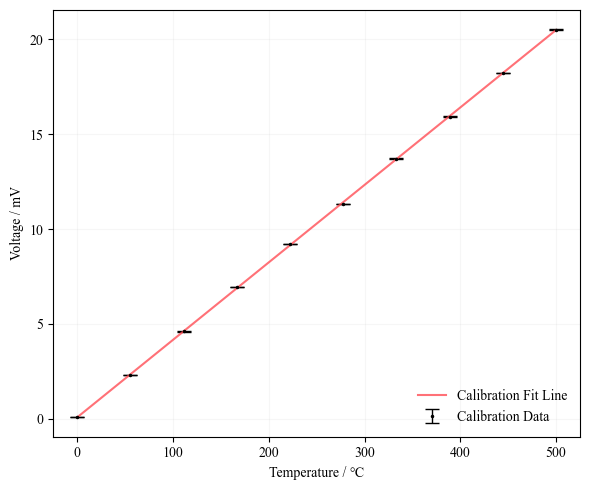

In [42]:
# plot calibration data
fig_calibration = plt.figure(figsize=(6, 5))
_, caps, bars = plt.errorbar(
    calibration_data['T'], 
    calibration_data['V'], 
    yerr=calibration_data['V_err'], 
    fmt='.k',
    markersize=3,
    elinewidth=1,
    ecolor='k',
    capsize=5,
    label='Calibration Data'
    )

# plot fit line
fine_t = np.linspace(calibration_data['T'].min(), calibration_data['T'].max(), 1000)
plt.plot(
    fine_t,
    np.polyval(calibration_coeffs, fine_t),
    color='#ff4d55',
    alpha=0.8,
    label='Calibration Fit Line'
)

# style graph
plt.grid(alpha=0.1)

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"]
plt.xlabel("Temperature / ℃")
plt.ylabel("Voltage / mV")

plt.legend(frameon=False, loc='lower right')
plt.tight_layout()
plt.show()

# save graph
fig_calibration.savefig('t1_calibration.png', dpi=300)

##### Heat Transfer Investigation

Experimental data is analysed to fit to Newton's Law of cooling which states that the rate of change of temperature difference is proportional to the temperature difference itself,

\begin{equation}
    \Theta = \Theta_0 e^{-\beta t},
\end{equation}

which can be linearised for easier fitting to:

\begin{equation}
    ln(\Theta) = -\beta T + ln(\Theta_0).
\end{equation}

Using partial differentiation methods for error propagation assuming all variables are independent the errors in slope and intercept for the relation between $V$ and $T$ and the errors in the data in $V$ is combined and displayed to calculate $\beta$ in this experiment.

In [43]:
# import time-voltage data from experiment
data = pd.read_csv(DATA_PATH)

# calculate voltage error
data['V_err'] = VOLTMETER_SENSITIVITY

# convert voltages to values of theta and then apply lns to linearise the expression
temperatures = []
temperatures_errs = []

V, b, a, T = sp.symbols('V b a T')
f = sp.ln(((V-b)/a) - T)

for i in range(len(data['V'])):
    value = data['V'][i]
    error = data['V_err'][i]

    theta, err = propagate_error_pd(
        f,
        {
            V: (value, error),
            b: (calibration_coeffs[1], calibration_errs[1]),
            a: (calibration_coeffs[0], calibration_errs[0]),
            T: (EQUILIBRIUM_TEMP, 0)
        }
    ) 
    
    temperatures.append(theta)
    temperatures_errs.append(err)

data['ln(theta)'] = np.array(temperatures, dtype='float64')
data['ln(theta)_err'] = np.array(temperatures_errs, dtype='float64')

In [44]:
# perform fit on linear data
model_coeffs, model_cov = np.polyfit(
    data['t'],
    data['ln(theta)'],
    deg=1,
    w = 1/data['ln(theta)_err'],
    cov=True
)

model_errs = np.diag(model_cov)

print(f"Slope: {model_coeffs[0]:.3f}±{model_errs[0]:.3f} ln(K)/s")
print(f"Intercept: {model_coeffs[1]:.3f}±{model_errs[1]:.3f} ln(K)")

Slope: -0.005±0.000 ln(K)/s
Intercept: 5.165±0.000 ln(K)


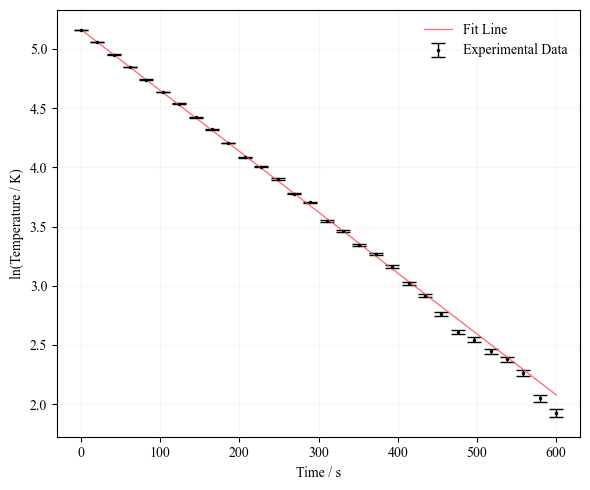

In [45]:
# plot linear data
fig_data = plt.figure(figsize=(6, 5))

# experimental data
plt.errorbar(
    data['t'], 
    data['ln(theta)'], 
    yerr=data['ln(theta)_err'],
    fmt='.k',
    markersize=3,
    ecolor='k',
    elinewidth=1,
    capsize=5,
    label='Experimental Data'
)

# model data
fine_t = np.linspace(
    min(data['t']),
    max(data['t']),
    10000
)

plt.plot(
    fine_t,
    np.polyval(model_coeffs, fine_t),
    color='#ff4d55',
    alpha=0.8,
    linewidth=1,
    label='Fit Line'
)

# style graph
plt.grid(alpha=0.1)

plt.xlabel("Time / s")
plt.ylabel("ln(Temperature / K)")

plt.legend(frameon=False, loc='upper right')

plt.tight_layout()
plt.show()

# save graph
fig_data.savefig('t1_data.png', dpi=300)